In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import npts

DATA_DIR = 'data/'

In [94]:
tides = pd.read_csv(DATA_DIR+'point_reyes_tides_1995-12-31_2018-01-31.csv.gz', 
                    parse_dates=[0], index_col=0, usecols=[0,1,7])

# I couldn't find the specification of the data. I assume the the has values "p" and "v" in the "Quality" field stand
# for "preliminary" and "verified". I discard preliminar data.

water_level = tides[tides[' Quality '] == 'v'][' Water Level']
del tides

print('we have years:', set(water_level.index.year))
data_used = water_level[water_level.index.year <= 2015]
indep_test = water_level[water_level.index.year > 2015]


we have years: {1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}


In [95]:
predictions = pd.read_csv('data/point_reyes_noaa_predictions_1995-12-31_2018-02-28.csv.gz',
                          parse_dates=[0], index_col=0)

predictions_test = predictions[(predictions.index.year > 2015) & (predictions.index <= water_level.index[-1])]
predictions_test = predictions_test.iloc[:,0]

## NOAA predictions test RMSE 

In [96]:
def RMSE(x, y):
    assert x.shape == y.shape
    return np.sqrt(np.mean(np.square(x-y)))

RMSE(predictions_test, indep_test)

0.10903741954838289

In [97]:
MIN_REG = 1E-9 * np.abs(data_used).mean()
MAX_REG = MIN_REG * 1E9
print(MIN_REG, MAX_REG)

9.78634778715e-10 0.978634778715


In [116]:
indep_test_rmse = pd.DataFrame()
time_taken = pd.DataFrame()
model_objs = pd.DataFrame()

In [115]:
day_seconds = 86400
tropical_year_seconds = 365.24219 * day_seconds
moon_cycle_seconds = 27.321661 * day_seconds

models_modelnames = [
    
    [npts.Baseline(npts.DayOfYear(lambdas=[MIN_REG]),
                   npts.LunarPhase(n_periods=48, lambdas=[MIN_REG])), 'day and moon', 1.],

    [npts.Baseline(npts.IntervalOfDay(n_seconds=900, lambdas=[MIN_REG]),
                   npts.LunarPhase(n_periods=48, lambdas=[MIN_REG])), 'time and moon', 1.],
    
    [npts.Baseline(npts.IntervalOfDay(n_seconds=900, lambdas=[MIN_REG]),
                   npts.DayOfYear(lambdas=[MIN_REG])), 'time and day', 1.],
    
    [npts.Baseline(npts.DayOfYear(lambdas=[MIN_REG]),
               npts.IntervalOfDay(n_seconds=900, lambdas=[MIN_REG]),
                     npts.LunarPhase(n_periods=48,lambdas=[MIN_REG]),
              verbose=True), 'time and day and moon', 1.],

    [npts.Baseline(npts.DayOfYear(lambdas=np.logspace(np.log10(MIN_REG),np.log10(MAX_REG), 6)),
               npts.IntervalOfDay(n_seconds=900, lambdas=np.logspace(np.log10(MIN_REG),np.log10(MAX_REG), 6)),
               npts.LunarPhase(n_periods=48,lambdas=np.logspace(np.log10(MIN_REG),np.log10(MAX_REG), 6)),
              verbose=True), 
    'time and day and moon reg.', .75],
    
    [npts.Harmonic([day_seconds, tropical_year_seconds, moon_cycle_seconds]), 
                     'daily and annual and lunar harmonic', .75]

]

building reg matrices
building reg matrices
building reg matrices
Building baseline with 1686528 =  366*96*48 values.
building reg matrices
Building baseline with 1686528 =  366*96*48 values.
building reg matrices


In [105]:
# day_seconds = 86400
# tropical_year_seconds = 365.24219 * day_seconds
# moon_cycle_seconds = 27.321661 * day_seconds

# models_modelnames = [
# #     [npts.Baseline(npts.DayOfYear(lambdas=[1E-9]),
# #                    npts.LunarPhase(n_periods=48, lambdas=[1E-9])), 'day-of-year and moon-phase avg.', 1.],

# #     [npts.Baseline(npts.IntervalOfDay(n_seconds=900, lambdas=[1E-9]),
# #                    npts.LunarPhase(n_periods=48,lambdas=[1E-9])), 'interval-of-day and moon-phase avg.', 1.],
    
# #     [npts.Baseline(npts.IntervalOfDay(n_seconds=900, lambdas=[1E-9]),
# #                    npts.DayOfYear(lambdas=[1E-9])), 'interval-of-day and day-of-year avg.', 1.],
    
# #     [npts.Baseline(npts.DayOfYear(lambdas=[1E-9]),
# #                npts.IntervalOfDay(n_seconds=900, lambdas=[1E-9]),
# #                      npts.LunarPhase(n_periods=48,lambdas=[1E-9]),
# #               verbose=True), 'moon-phase and interval-of-day and day-of-year avg.', 1.],

# #     [npts.Baseline(npts.DayOfYear(lambdas=np.logspace(-9,-5, 6)),
# #                npts.IntervalOfDay(n_seconds=900, lambdas=np.logspace(-9,-5, 6)),
# #                npts.LunarPhase(n_periods=48,lambdas=np.logspace(-9,-5, 6)),
# #               verbose=True), 'moon-phase and interval-of-day and day-of-year bas.', .75],
    
#     [npts.Harmonic([day_seconds, tropical_year_seconds, moon_cycle_seconds]), 
#                      'daily and annual and lunar harmonic', .75]

# ]

In [117]:
for el in models_modelnames:
    el[1] += f' n_par = {el[0].cum_periods[-1]}'

AttributeError: 'Harmonic' object has no attribute 'cum_periods'

In [118]:
np.random.seed(0)

import time 
import copy

def sparsify_data(data, frac):
    return data[np.random.uniform(size=len(data)) < frac]

for data in [sparsify_data(data_used, target/len(data_used)) for target in (1E7,)]:# 1E6, 1E5, 1E4)]:
    dataname = f'M = {len(data)}'
    print(dataname)
    for model, modelname, train_frac in models_modelnames:
        model_used = copy.copy(model)
        print(f'fitting {modelname} using {100*train_frac:.0f}% train data')
        model_objs.loc[dataname, modelname] = model_used
        s = time.time()
        model_used.fit(data,train_frac=train_frac, last_is_test=True) ## NOTE THIS!
        time_taken.loc[dataname, modelname] = time.time() - s
        pred = model_used.predict(indep_test.index)
        indep_test_rmse.loc[dataname, modelname] = np.sqrt(np.mean((indep_test - pred)**2)) 

M = 1741985
fitting day and moon n_par = 17568 using 100% train data
fitting time and moon n_par = 4608 using 100% train data
fitting time and day n_par = 35136 using 100% train data
fitting time and day and moon n_par = 1686528 using 100% train data
Fitting on 1741985 observations, of dimension 1
Train set: 1741985 obs. Test set : 0 obs.
Making quadratic loss term for 1741985 obs.
Making quadratic loss term for 0 obs.
Provided lambdas: [[9.7863477871508675e-10], [9.7863477871508675e-10], [9.7863477871508675e-10]]
working with lambda (9.7863477871508675e-10, 9.7863477871508675e-10, 9.7863477871508675e-10)
solving with λ=(9.7863477871508675e-10, 9.7863477871508675e-10, 9.7863477871508675e-10)
CG took 1.534527063369751 seconds.
Val. cost: 0.000e+00
Best λ = (9.7863477871508675e-10, 9.7863477871508675e-10, 9.7863477871508675e-10)
fitting time and day and moon reg. n_par = 1686528 using 75% train data
Fitting on 1741985 observations, of dimension 1
Train set: 1306488 obs. Test set : 435497

CG took 14.200151205062866 seconds.
Val. cost: 2.786e-01
working with lambda (9.7863477871508592e-10, 0.015510315986912285, 0.97863477871508675)
solving with λ=(9.7863477871508592e-10, 0.015510315986912285, 0.97863477871508675)
CG took 19.265666246414185 seconds.
Val. cost: 2.787e-01
working with lambda (9.7863477871508592e-10, 0.97863477871508675, 9.7863477871508592e-10)
solving with λ=(9.7863477871508592e-10, 0.97863477871508675, 9.7863477871508592e-10)
CG took 190.02712512016296 seconds.
Val. cost: 3.376e-01
working with lambda (9.7863477871508592e-10, 0.97863477871508675, 6.1747680119403186e-08)
solving with λ=(9.7863477871508592e-10, 0.97863477871508675, 6.1747680119403186e-08)
CG took 79.42153811454773 seconds.
Val. cost: 3.411e-01
working with lambda (9.7863477871508592e-10, 0.97863477871508675, 3.8960152275951041e-06)
solving with λ=(9.7863477871508592e-10, 0.97863477871508675, 3.8960152275951041e-06)
CG took 109.08385109901428 seconds.
Val. cost: 2.842e-01
working with lambda 

CG took 41.720722913742065 seconds.
Val. cost: 2.786e-01
working with lambda (6.1747680119403186e-08, 0.015510315986912285, 0.015510315986912285)
solving with λ=(6.1747680119403186e-08, 0.015510315986912285, 0.015510315986912285)
CG took 14.375245809555054 seconds.
Val. cost: 2.785e-01
working with lambda (6.1747680119403186e-08, 0.015510315986912285, 0.97863477871508675)
solving with λ=(6.1747680119403186e-08, 0.015510315986912285, 0.97863477871508675)
CG took 19.235153913497925 seconds.
Val. cost: 2.786e-01
working with lambda (6.1747680119403186e-08, 0.97863477871508675, 9.7863477871508592e-10)
solving with λ=(6.1747680119403186e-08, 0.97863477871508675, 9.7863477871508592e-10)
CG took 59.752824783325195 seconds.
Val. cost: 3.578e-01
working with lambda (6.1747680119403186e-08, 0.97863477871508675, 6.1747680119403186e-08)
solving with λ=(6.1747680119403186e-08, 0.97863477871508675, 6.1747680119403186e-08)
CG took 42.559478759765625 seconds.
Val. cost: 3.062e-01
working with lambda (

CG took 54.236244916915894 seconds.
Val. cost: 2.784e-01
working with lambda (3.8960152275951041e-06, 0.015510315986912285, 0.015510315986912285)
solving with λ=(3.8960152275951041e-06, 0.015510315986912285, 0.015510315986912285)
CG took 36.2686550617218 seconds.
Val. cost: 2.784e-01
working with lambda (3.8960152275951041e-06, 0.015510315986912285, 0.97863477871508675)
solving with λ=(3.8960152275951041e-06, 0.015510315986912285, 0.97863477871508675)
CG took 50.92790699005127 seconds.
Val. cost: 2.785e-01
working with lambda (3.8960152275951041e-06, 0.97863477871508675, 9.7863477871508592e-10)
solving with λ=(3.8960152275951041e-06, 0.97863477871508675, 9.7863477871508592e-10)
CG took 63.651968002319336 seconds.
Val. cost: 3.062e-01
working with lambda (3.8960152275951041e-06, 0.97863477871508675, 6.1747680119403186e-08)
solving with λ=(3.8960152275951041e-06, 0.97863477871508675, 6.1747680119403186e-08)
CG took 39.807225704193115 seconds.
Val. cost: 2.991e-01
working with lambda (3.8

CG took 55.8271107673645 seconds.
Val. cost: 2.782e-01
working with lambda (0.00024582194220578064, 0.015510315986912285, 0.00024582194220578064)
solving with λ=(0.00024582194220578064, 0.015510315986912285, 0.00024582194220578064)
CG took 38.11408495903015 seconds.
Val. cost: 2.775e-01
working with lambda (0.00024582194220578064, 0.015510315986912285, 0.015510315986912285)
solving with λ=(0.00024582194220578064, 0.015510315986912285, 0.015510315986912285)
CG took 41.39363622665405 seconds.
Val. cost: 2.780e-01
working with lambda (0.00024582194220578064, 0.015510315986912285, 0.97863477871508675)
solving with λ=(0.00024582194220578064, 0.015510315986912285, 0.97863477871508675)
CG took 106.08626294136047 seconds.
Val. cost: 2.781e-01
working with lambda (0.00024582194220578064, 0.97863477871508675, 9.7863477871508592e-10)
solving with λ=(0.00024582194220578064, 0.97863477871508675, 9.7863477871508592e-10)
CG took 284.4955778121948 seconds.
Val. cost: 2.812e-01
working with lambda (0.0

CG took 66.04212188720703 seconds.
Val. cost: 2.787e-01
working with lambda (0.015510315986912285, 0.015510315986912285, 0.00024582194220578064)
solving with λ=(0.015510315986912285, 0.015510315986912285, 0.00024582194220578064)
CG took 28.479948043823242 seconds.
Val. cost: 2.788e-01
working with lambda (0.015510315986912285, 0.015510315986912285, 0.015510315986912285)
solving with λ=(0.015510315986912285, 0.015510315986912285, 0.015510315986912285)
CG took 5.844209909439087 seconds.
Val. cost: 2.795e-01
working with lambda (0.015510315986912285, 0.015510315986912285, 0.97863477871508675)
solving with λ=(0.015510315986912285, 0.015510315986912285, 0.97863477871508675)
CG took 72.30577611923218 seconds.
Val. cost: 2.796e-01
working with lambda (0.015510315986912285, 0.97863477871508675, 9.7863477871508592e-10)
solving with λ=(0.015510315986912285, 0.97863477871508675, 9.7863477871508592e-10)
CG took 127.4581789970398 seconds.
Val. cost: 2.809e-01
working with lambda (0.0155103159869122

KeyboardInterrupt: 

In [28]:
# import matplotlib.pyplot as plt
# def plot_RMSE(baseline):
#     ref = ['day-of-year', 'interval-of-day', 'moonphase']
#     for pat in [[0,1], [0,2], [1,2]]:
#         for cost_dict, title in [[baseline.val_costs, 'test']]:#, 
#                                  #[baseline.tr_costs, 'train']]:
#             fig = plt.figure(figsize=(8,4))
#             cax = plt.hexbin(*np.array([[*(np.log10(k)[pat]), np.sqrt(v)] for k, v 
#                                   in cost_dict.items()]).T,
#                       gridsize=5)
#             axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
#             plt.plot(*np.log10(baseline.best_lambda)[pat], 'ro', markersize=10)
#             plt.xlabel(f'log10(λ_{ref[pat[0]]})')
#             plt.ylabel(f'log10(λ_{ref[pat[1]]})')
#             plt.title(title)
    
# plot_RMSE(model_objs.iloc[-3,-2])

In [108]:
indep_test_rmse

,day and moon n_par = 17568,time and moon n_par = 4608,time and day n_par = 35136,time and day and moon n_par = 1686528,time and moon n_par = 11520,time and day n_par = 87840,time and day and moon n_par = 4216320
M = 1741985,0.612051,0.514974,0.442157,0.151912,0.514981,0.442124,0.151113


In [103]:
indep_test_rmse

,day and moon n_par = 17568,time and moon n_par = 4608,time and day n_par = 35136,time and day and moon n_par = 1686528
M = 1741985,0.612051,0.514974,0.442157,0.151912


In [29]:
indep_test_rmse

,day-of-year and moon-phase avg. n_par = 17568,interval-of-day and moon-phase avg. n_par = 4608,interval-of-day and day-of-year avg. n_par = 35136,moon-phase and interval-of-day and day-of-year avg. n_par = 1686528,moon-phase and interval-of-day and day-of-year bas. n_par = 1686528,daily and annual and lunar harmonic
1.000000e+07 observations,0.612050,0.514974,0.442157,0.151909,0.137804,0.513849
1.000000e+06 observations,0.612798,0.515511,0.445189,0.150549,0.146128,0.513827
1.000000e+05 observations,0.632671,0.527111,0.523511,0.179279,0.160482,0.513587
1.000000e+04 observations,0.777787,0.721276,0.680966,1.121565,0.268568,0.514982


In [41]:
print(indep_test_rmse.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  day-of-year and moon-phase avg. n\_par = 17568 &  interval-of-day and moon-phase avg. n\_par = 4608 &  interval-of-day and day-of-year avg. n\_par = 35136 &  moon-phase and interval-of-day and day-of-year avg. n\_par = 1686528 &  moon-phase and interval-of-day and day-of-year bas. n\_par = 1686528 &  daily and annual and lunar harmonic \\
\midrule
1.000000e+07 observations &                                          0.612 &                                             0.515 &                                              0.442 &                                              0.152 &                                              0.138 &                                0.514 \\
1.000000e+06 observations &                                          0.613 &                                             0.516 &                                              0.445 &                                              0.151 &                                              0.

In [11]:
indep_test_rmse

,day-of-year and moon-phase avg.,interval-of-day and moon-phase avg.,interval-of-day and day-of-year avg.,moon-phase and interval-of-day and day-of-year avg.,moon-phase and interval-of-day and day-of-year bas.,daily and annual and lunar harmonic
1.000000e+06 observations,0.616933,0.515489,0.445986,0.154566,0.141232,0.513899
1.000000e+05 observations,0.687466,0.527130,0.578788,0.338433,0.163546,0.513731
1.000000e+04 observations,1.001705,0.710631,1.026622,1.135905,0.287533,0.514212


In [13]:
model_objs.iloc[-3,-2].best_lambda

(9.9999999999999995e-07, 9.9999999999999995e-08, 9.9999999999999995e-08)

In [14]:
model_objs.iloc[-2,-2].best_lambda

(1e-08, 1.0000000000000001e-09, 1e-10)

In [ ]:
model_objs.iloc[-1,-1].best_lambda

In [65]:
# win_s = int(np.random.uniform() * len(data_used))
# win_e = win_s + 200*5


# plt.figure(figsize=(14,5))
# model_objs.iloc[0, -2].predict(data_used.index[win_s:win_e]).plot(style='y--',label= 'mean, reg. fit, 1E6 obs.')
# model_objs.iloc[0, -1].predict(data_used.index[win_s:win_e]).plot(style='g--',label= 'prediction, reg. fit, 1E6 obs.')
# model_objs.iloc[-2, -1].predict(data_used.index[win_s:win_e]).plot(style='r--',label= 'prediction, reg. fit, 1E5 obs.')
# model_objs.iloc[-1, -1].predict(data_used.index[win_s:win_e]).plot(style='b--', label= 'prediction, reg. fit, 1E4 obs.')
# data_used[win_s:win_e].plot(label='real', style = 'k-')
# plt.legend(loc='lower left')

In [44]:
indep_test_rmse

,day-of-year and moon-phase avg. n_par = 17568,interval-of-day and moon-phase avg. n_par = 4608,interval-of-day and day-of-year avg. n_par = 35136,moon-phase and interval-of-day and day-of-year avg. n_par = 1686528,moon-phase and interval-of-day and day-of-year bas. n_par = 1686528,daily and annual and lunar harmonic
1.000000e+07 observations,0.612050,0.514974,0.442157,0.151909,0.137804,0.513849
1.000000e+06 observations,0.612798,0.515511,0.445189,0.150549,0.146128,0.513827
1.000000e+05 observations,0.632671,0.527111,0.523511,0.179279,0.160482,0.513587
1.000000e+04 observations,0.777787,0.721276,0.680966,1.121565,0.268568,0.514982


In [82]:
model_objs.iloc[0, -2].theta.shape

(1686528, 1)

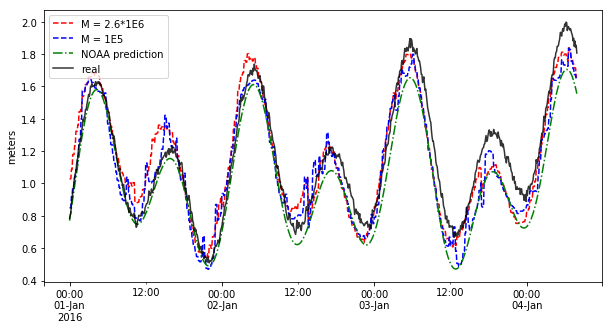

In [86]:
indep_test.index.name = ''
win_s = 0#int(np.random.uniform() * len(indep_test))
win_e = win_s + 200*4


plt.figure(figsize=(10,5))
model_objs.iloc[0, -2].predict(indep_test.index[win_s:win_e]).plot(style='r--', label= 'M = 2.6*1E6')
model_objs.iloc[-2, -2].predict(indep_test.index[win_s:win_e]).plot(style='b--',label= 'M = 1E5')
predictions_test[win_s:win_e].plot(label='NOAA prediction', style = 'g-.')
indep_test[win_s:win_e].plot(label='real', style = 'k-', alpha=.8)
plt.legend(loc='upper left')
plt.ylabel('meters')

plt.savefig('../fig/tides_prediction.pdf')

In [62]:
# win_e = 200*2
# win_s = 0

# plt.figure(figsize=(14,5))
# model_objs.iloc[-3, -2].predict(indep_test.index[win_s:win_e]).plot(style='y--',label= 'mean, reg. fit, 1E6 obs.')
# #model_objs.iloc[-3, -1].predict(indep_test.index[win_s:win_e]).plot(style='g--',label= 'prediction, reg. fit, 1E6 obs.')
# #model_objs.iloc[-2, -1].predict(indep_test.index[win_s:win_e]).plot(style='r--',label= 'prediction, reg. fit, 1E5 obs.')
# #model_objs.iloc[-1, -1].predict(indep_test.index[win_s:win_e]).plot(style='b--', label= 'prediction, reg. fit, 1E4 obs.')
# indep_test[win_s:win_e].plot(label='real', style = 'k-')
# plt.legend(loc='lower left')